In [1]:
generated_records = [{
        'skills': ['SQL', 'Hadoop', 'machine learning'],
        'sentence': 'We are currently seeking a skilled and dynamic Data Engineer to join our team. As a Data Engineer, you will be responsible for designing and optimizing our data infrastructure, utilizing your expertise in SQL, Hadoop, and machine learning. Your in-depth knowledge of SQL will enable you to design efficient and scalable database structures, while your experience with Hadoop will allow you to process and analyze large volumes of data. Additionally, your proficiency in machine learning will enable you to develop and implement advanced data models, helping us extract valuable insights from our vast datasets. The ideal candidate will possess a strong understanding of these technologies and a proven track record of successfully implementing data-driven solutions. Join us and contribute to our mission of leveraging data to drive business growth and innovation.'
    },
    {
        'skills': ['SQL', 'Hadoop', 'machine learning'],
        'sentence': 'We are seeking a highly skilled candidate with expertise in data manipulation using query languages, proficiency in big data processing frameworks, and a strong knowledge of advanced data analysis techniques.'
    }
]

In [2]:
import pickle
from api_key import API_KEY
import pandas as pd
from tqdm.notebook import tqdm
import sys
sys.path.append("../../skillExtract/")
from utils import (OPENAI,
                   Splitter,
                   select_candidates_from_taxonomy)
from api_key import API_KEY
from transformers import AutoModel, AutoTokenizer
import os
import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

tqdm.pandas()

ESCO_DIR = "../../../esco/"

class Args():
    def __init__(self):
        self.taxonomy = ESCO_DIR + "tech_managment_taxonomy.csv" 

        ## RELATED TO PROMPT CREATION
        self.datapath = "remote-annotated-en"
        # self.candidates_method = "embeddings"  ## putting "rules" doesn't give the embeddings
        self.candidates_method = "mixed"
        self.shots = 6
        self.prompt_type = "skills"
        self.data_type = "en_job"
        
        ## RELATED TO CHAT GPT GENERATION
        self.max_tokens = 200      ## ?? default value but JobBERT suposedly takes 512
        self.api_key = API_KEY
        self.model = "gpt-3.5-turbo"
        self.temperature = 0       ## default val
        self.top_p = 1             ## default val
        self.frequency_penalty = 0 ## default val
        self.presence_penalty = 0  ## default val

args = Args()

## Loading the embedded taxonomy
word_emb = "jjzha/jobbert-base-cased"
word_emb_model = AutoModel.from_pretrained(word_emb)
word_emb_tokenizer = AutoTokenizer.from_pretrained(word_emb)

## ESCO technical skills
ESCO_DIR = "../../../../esco/"
tech_skills = pd.read_csv(ESCO_DIR + "tech_managment_taxonomy_narrow.csv")
tech_skills["name+definition"] = tech_skills["name+defintion"]
tech_skills["Example"] = tech_skills["altLabels"]


if(not os.path.exists(ESCO_DIR + "embedded_tech_management_tax.pkl")):
    tech_emb_tax = tech_skills[["name+definition", "name", "unique_id"]].copy()
    tech_emb_tax["embeddings"] = tech_emb_tax["name+definition"]\
                        .progress_apply(lambda st : \
                        word_emb_model(**word_emb_tokenizer(st, return_tensors="pt", max_length=768, padding=True, truncation=True))\
                        .last_hidden_state[:, 0, :]\
                        )
else:
    with open(ESCO_DIR + "embedded_tech_management_tax.pkl", "rb") as emb:
        tech_emb_tax =  pickle.load(emb)

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# with open(ESCO_DIR + "embedded_tech_management_tax.pkl", "wb") as emb:
#     pickle.dump(tech_emb_tax, emb)

In [2]:
def compute_prediction(generated_records):
    extraction_cost = 0
    matching_cost = 0
    ress = []
    for i, annotated_record in tqdm(enumerate(generated_records)):
        if(i>20):
            break
        print(annotated_record)

        ## EXTRACTION
        api = OPENAI(args, [annotated_record])
        sentences_res_list, cost = api.do_prediction("extraction")
        extraction_cost += cost
        

        ## CANDIDATE SELECTION
        if "extracted_skills" in sentences_res_list[0]:
            splitter = Splitter()
            max_candidates = 10
            for idxx, sample in enumerate(sentences_res_list):
                sample = select_candidates_from_taxonomy(
                    sample,
                    tech_skills,
                    splitter,
                    word_emb_model,
                    word_emb_tokenizer,
                    max_candidates,
                    method=args.candidates_method,
                    emb_tax=None if args.candidates_method == "rules" else tech_emb_tax
                )
                sentences_res_list[idxx] = sample


        if("skill_candidates" in sentences_res_list[0]):
            api = OPENAI(args, sentences_res_list)
            sentences_res_list, cost = api.do_prediction("matching")
            matching_cost += cost



        ress.append(sentences_res_list)
    return ress

In [ ]:
compute_prediction([{
    "sentence": "We want someone who can use IBM Informix.",
    "skill": ["IBM Informix"]
}])

In [ ]:
compute_prediction([{
    "sentence": "We want someone proficient with Hadoop and HDFS.",
    "skill": ["SQL"]
}])

In [ ]:
ress = compute_prediction(generated_records)

In [11]:
for res in ress:
    print("-"*100)
    print("labels : ", res[0]["skills"])
    for sk in res[0]["matched_skills"]:
        print("span : ", sk)
        print("\t - ", res[0]["matched_skills"][sk]["name+definition"])
    

----------------------------------------------------------------------------------------------------
labels :  ['SQL', 'Hadoop', 'machine learning']
span :  data engineer
	 -  use data processing techniques : gather, process and analyse relevant data and information, properly store and update data and represent figures and data using charts and statistical diagrams.
span :  designing and optimizing our data infrastructure
	 -  database development tools : the methodologies and tools used for creating logical and physical structure of databases, such as logical data structures, diagrams, modelling methodologies and entity-relationships.
span :  sql, hadoop, and machine learning
	 -  apply statistical analysis techniques : use models (descriptive or inferential statistics) and techniques (data mining or machine learning) for statistical analysis and ict tools to analyse data, uncover correlations and forecast trends.
span :  sql
	 -  SQL : the computer language sql is a query language fo

### Few specific embeddings


The whole matching part consists of comparing the span and the skills but does it work ?

In [9]:
vec = word_emb_model(**word_emb_tokenizer("SQL", return_tensors="pt", max_length=768, padding=True, truncation=True)).last_hidden_state[:, 0, :]
tech_emb_tax["similarity"] = tech_emb_tax["embeddings"].apply(lambda x : F.cosine_similarity(vec, x).item())

quest = tech_emb_tax.sort_values("similarity", ascending=False).reset_index()
quest

,index,name+definition,name,unique_id,embeddings,similarity,results
0,1184,database management systems : the tools for cr...,database management systems,2184,"[[tensor(0.3259, grad_fn=<UnbindBackward0>), t...",0.638282,False
1,783,operate relational database management system ...,operate relational database management system,1783,"[[tensor(0.4806, grad_fn=<UnbindBackward0>), t...",0.627278,False
2,1230,Jboss : the open-source application server jbo...,Jboss,2230,"[[tensor(0.8781, grad_fn=<UnbindBackward0>), t...",0.623659,False
3,1548,Oracle Relational Database : the computer prog...,Oracle Relational Database,2548,"[[tensor(0.5813, grad_fn=<UnbindBackward0>), t...",0.618193,False
4,327,Octopus Deploy : the tool octopus deploy is a ...,Octopus Deploy,1327,"[[tensor(0.6682, grad_fn=<UnbindBackward0>), t...",0.617577,False
...,...,...,...,...,...,...,...
1789,1282,engage in debates : construct and present argu...,engage in debates,2282,"[[tensor(0.7155, grad_fn=<UnbindBackward0>), t...",0.295587,False
1790,181,stimulate performers' imagination : use inspir...,stimulate performers' imagination,1181,"[[tensor(-0.3790, grad_fn=<UnbindBackward0>), ...",0.292352,False
1791,1452,develop cultural policies : develop programmes...,develop cultural policies,2452,"[[tensor(0.8760, grad_fn=<UnbindBackward0>), t...",0.290595,False
1792,462,conduct research on climate processes : conduc...,conduct research on climate processes,1462,"[[tensor(0.1406, grad_fn=<UnbindBackward0>), t...",0.270809,False


In [24]:
display(quest[quest.name == "SQL"])
display(quest[quest.name == "NoSQL"])

,index,name+definition,name,unique_id,embeddings,similarity
170,615,SQL : the computer language sql is a query lan...,SQL,1615,"[[tensor(0.3752, grad_fn=<UnbindBackward0>), t...",0.529819


,index,name+definition,name,unique_id,embeddings,similarity
24,814,NoSQL : the not only sql non-relational databa...,NoSQL,1814,"[[tensor(0.2357, grad_fn=<UnbindBackward0>), t...",0.59077


In [10]:
vec = word_emb_model(**word_emb_tokenizer("sql", return_tensors="pt", max_length=768, padding=True, truncation=True)).last_hidden_state[:, 0, :]
tech_emb_tax["similarity"] = tech_emb_tax["embeddings"].apply(lambda x : F.cosine_similarity(vec, x).item())

quest = tech_emb_tax.sort_values("similarity", ascending=False).reset_index()
quest

,index,name+definition,name,unique_id,embeddings,similarity,results
0,1051,operate GPS systems : use gps systems.,operate GPS systems,2051,"[[tensor(1.0385, grad_fn=<UnbindBackward0>), t...",0.618310,False
1,587,Aircrack (penetration testing tool) : the comp...,Aircrack (penetration testing tool),1587,"[[tensor(1.2083, grad_fn=<UnbindBackward0>), t...",0.598707,False
2,291,strive for company growth : develop strategies...,strive for company growth,1291,"[[tensor(0.6989, grad_fn=<UnbindBackward0>), t...",0.598563,False
3,718,STAF : the tool staf is a software program to ...,STAF,1718,"[[tensor(0.6350, grad_fn=<UnbindBackward0>), t...",0.593602,False
4,612,APL : the techniques and principles of softwar...,APL,1612,"[[tensor(0.8778, grad_fn=<UnbindBackward0>), t...",0.579703,False
...,...,...,...,...,...,...,...
1789,523,increase the impact of science on policy and s...,increase the impact of science on policy and s...,1523,"[[tensor(1.0667, grad_fn=<UnbindBackward0>), t...",0.329562,False
1790,68,implement route planning in smart mobility ser...,implement route planning in smart mobility ser...,1068,"[[tensor(0.6432, grad_fn=<UnbindBackward0>), t...",0.329421,False
1791,1282,engage in debates : construct and present argu...,engage in debates,2282,"[[tensor(0.7155, grad_fn=<UnbindBackward0>), t...",0.321549,False
1792,169,prevent fraudulent activities : identify and p...,prevent fraudulent activities,1169,"[[tensor(0.5965, grad_fn=<UnbindBackward0>), t...",0.297933,False


In [14]:
vec = word_emb_model(**word_emb_tokenizer("NoSQL", return_tensors="pt", max_length=768, padding=True, truncation=True)).last_hidden_state[:, 0, :]
tech_emb_tax["similarity"] = tech_emb_tax["embeddings"].apply(lambda x : F.cosine_similarity(vec, x).item())

quest = tech_emb_tax.sort_values("similarity", ascending=False).reset_index()
quest

,index,name+definition,name,unique_id,embeddings,similarity,results
0,814,NoSQL : the not only sql non-relational databa...,NoSQL,1814,"[[tensor(0.2357, grad_fn=<UnbindBackward0>), t...",0.640971,False
1,1184,database management systems : the tools for cr...,database management systems,2184,"[[tensor(0.3259, grad_fn=<UnbindBackward0>), t...",0.613612,False
2,1604,MarkLogic : the nosql enterprise non-relationa...,MarkLogic,2604,"[[tensor(0.4266, grad_fn=<UnbindBackward0>), t...",0.603742,False
3,1116,search databases : search for information or p...,search databases,2116,"[[tensor(0.5731, grad_fn=<UnbindBackward0>), t...",0.599333,False
4,1230,Jboss : the open-source application server jbo...,Jboss,2230,"[[tensor(0.8781, grad_fn=<UnbindBackward0>), t...",0.593972,False
...,...,...,...,...,...,...,...
1789,119,develop agricultural policies : develop progra...,develop agricultural policies,1119,"[[tensor(0.8436, grad_fn=<UnbindBackward0>), t...",0.237274,False
1790,964,create an airport master plan : compose a mast...,create an airport master plan,1964,"[[tensor(0.2353, grad_fn=<UnbindBackward0>), t...",0.236642,False
1791,286,prepare exhibition marketing plan : develop ma...,prepare exhibition marketing plan,1286,"[[tensor(1.1266, grad_fn=<UnbindBackward0>), t...",0.236013,False
1792,15,provide context to news stories : provide subs...,provide context to news stories,1015,"[[tensor(0.6254, grad_fn=<UnbindBackward0>), t...",0.229355,False


In [29]:
vec = word_emb_model(**word_emb_tokenizer("big data processing frameworks", return_tensors="pt", max_length=768, padding=True, truncation=True)).last_hidden_state[:, 0, :]
tech_emb_tax["similarity"] = tech_emb_tax["embeddings"].apply(lambda x : F.cosine_similarity(vec, x).item())

quest = tech_emb_tax.sort_values("similarity", ascending=False).reset_index()
quest

,index,name+definition,name,unique_id,embeddings,similarity,results
0,1580,"Hadoop : the open-source data storing, analysi...",Hadoop,2580,"[[tensor(0.5392, grad_fn=<UnbindBackward0>), t...",0.822168,False
1,265,data mining : the methods of artificial intell...,data mining,1265,"[[tensor(0.8332, grad_fn=<UnbindBackward0>), t...",0.802054,False
2,1059,resource description framework query language ...,resource description framework query language,2059,"[[tensor(0.5560, grad_fn=<UnbindBackward0>), t...",0.787018,False
3,290,manage database : apply database design scheme...,manage database,1290,"[[tensor(0.6113, grad_fn=<UnbindBackward0>), t...",0.786879,False
4,902,utilise machine learning : use techniques and ...,utilise machine learning,1902,"[[tensor(0.9736, grad_fn=<UnbindBackward0>), t...",0.780613,False
...,...,...,...,...,...,...,...
1789,1178,participate in rabbinical court proceedings : ...,participate in rabbinical court proceedings,2178,"[[tensor(0.3299, grad_fn=<UnbindBackward0>), t...",0.326043,False
1790,688,develop outreach training plans : develop trai...,develop outreach training plans,1688,"[[tensor(0.3241, grad_fn=<UnbindBackward0>), t...",0.324389,False
1791,485,provide testimony in court hearings : provide ...,provide testimony in court hearings,1485,"[[tensor(0.6440, grad_fn=<UnbindBackward0>), t...",0.307927,False
1792,1268,provide animal related information for legal p...,provide animal related information for legal p...,2268,"[[tensor(0.5757, grad_fn=<UnbindBackward0>), t...",0.305936,False


In [39]:
vec = word_emb_model(**word_emb_tokenizer("machine learning", return_tensors="pt", max_length=768, padding=True, truncation=True)).last_hidden_state[:, 0, :]
tech_emb_tax["similarity"] = tech_emb_tax["embeddings"].apply(lambda x : F.cosine_similarity(vec, x).item())

quest = tech_emb_tax.sort_values("similarity", ascending=False).reset_index()
quest

,index,name+definition,name,unique_id,embeddings,similarity,results
0,265,data mining : the methods of artificial intell...,data mining,1265,"[[tensor(0.8332, grad_fn=<UnbindBackward0>), t...",0.744104,False
1,902,utilise machine learning : use techniques and ...,utilise machine learning,1902,"[[tensor(0.9736, grad_fn=<UnbindBackward0>), t...",0.692355,False
2,388,"machine learning : the principles, methods and...",machine learning,1388,"[[tensor(1.0222, grad_fn=<UnbindBackward0>), t...",0.688033,False
3,290,manage database : apply database design scheme...,manage database,1290,"[[tensor(0.6113, grad_fn=<UnbindBackward0>), t...",0.656007,False
4,1059,resource description framework query language ...,resource description framework query language,2059,"[[tensor(0.5560, grad_fn=<UnbindBackward0>), t...",0.652568,False
...,...,...,...,...,...,...,...
1789,1268,provide animal related information for legal p...,provide animal related information for legal p...,2268,"[[tensor(0.5757, grad_fn=<UnbindBackward0>), t...",0.252162,False
1790,819,represent clients in courts : assume the posit...,represent clients in courts,1819,"[[tensor(0.6174, grad_fn=<UnbindBackward0>), t...",0.250387,False
1791,1178,participate in rabbinical court proceedings : ...,participate in rabbinical court proceedings,2178,"[[tensor(0.3299, grad_fn=<UnbindBackward0>), t...",0.244656,False
1792,485,provide testimony in court hearings : provide ...,provide testimony in court hearings,1485,"[[tensor(0.6440, grad_fn=<UnbindBackward0>), t...",0.240261,False


In [10]:
skills = tech_skills.name.values
self_reflection = []
for skill in tqdm(skills):
    vec = word_emb_model(**word_emb_tokenizer(skill, return_tensors="pt", max_length=768, padding=True, truncation=True)).last_hidden_state[:, 0, :]
    tech_emb_tax["similarity"] = tech_emb_tax["embeddings"].apply(lambda x : F.cosine_similarity(vec, x).item())

    quest = tech_emb_tax.sort_values("similarity", ascending=False).reset_index()
    self_reflection.append(quest[quest.name == skill].index[0])

  0%|          | 0/1794 [00:00<?, ?it/s]

In [11]:
self_reflection = pd.DataFrame({
    'skills': skills,
    "self_reflection": self_reflection
})

In [12]:
self_reflection.sort_values("self_reflection").describe()

,self_reflection
count,1794.000000
mean,18.784281
std,89.751735
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,1463.000000


In [22]:
self_reflection[self_reflection.skills == "MySQL"]

,skills,self_reflection
526,MySQL,1


In [23]:
self_reflection[self_reflection.self_reflection >= 10].sample(50)

,skills,self_reflection
1003,integrated development environment software,46
1587,SAS Data Management,12
1530,study a collection,20
34,perform online data analysis,46
419,assemble hardware components,13
1410,scientific modelling,215
541,perform scientific research,14
642,analyse business plans,70
20,Erlang,16
1063,perform PESTEL analysis,160


In [44]:
self_reflection.sort_values("self_reflection", ascending=False).head(50)

,skills,self_reflection
271,LESS,1671
1464,read manuscripts,1479
1208,SPARK,1401
925,discuss artwork,1369
1612,observe matter,1352
1172,Sakai,1295
932,JSSS,1221
1462,model groundwater,1197
612,APL,970
196,MDX,943


In [47]:
display(self_reflection[self_reflection.skills == "SQL"])
display(self_reflection[self_reflection.skills == "machine learning"])
display(self_reflection[self_reflection.skills == "Hadoop"])

,skills,self_reflection
615,SQL,170


,skills,self_reflection
388,machine learning,2


,skills,self_reflection
1580,Hadoop,1


With only lowercase :

In [63]:
skills = tech_skills.name.values
self_reflection = []
for skill in tqdm(skills):
    vec = word_emb_model(**word_emb_tokenizer(skill.lower(), return_tensors="pt", max_length=768, padding=True, truncation=True)).last_hidden_state[:, 0, :]
    tech_emb_tax["similarity"] = tech_emb_tax["embeddings"].apply(lambda x : F.cosine_similarity(vec, x).item())

    quest = tech_emb_tax.sort_values("similarity", ascending=False).reset_index()
    self_reflection.append(quest[quest.name == skill].index[0])

  0%|          | 0/1794 [00:00<?, ?it/s]

In [64]:
lower_self_reflection = pd.DataFrame({
    'skills': skills,
    "self_reflection": self_reflection
})

In [67]:
display(lower_self_reflection[lower_self_reflection.skills=="Hadoop"])
display(lower_self_reflection[lower_self_reflection.skills=="SQL"])

,skills,self_reflection
1580,Hadoop,37


,skills,self_reflection
615,SQL,206


In [71]:
lower_self_reflection[lower_self_reflection.self_reflection >= 10].describe()

,self_reflection
count,327.000000
mean,120.058104
std,241.821322
min,10.000000
25%,16.000000
50%,35.000000
75%,99.500000
max,1639.000000


### Prototype

In [17]:
with open("./generated/PROTOTYPE/prototype_split/train.pkl", 'rb') as f:
    df_train = pickle.load(f)
df_train.head(5)

,skills,sentence,embeddings
0,"[SQL, Oracle Relational Database, SAS Data Man...",We are currently seeking a highly skilled and ...,"[[tensor(0.3830, grad_fn=<UnbindBackward0>), t..."
1,"[evaluate training, develop curriculum, manage...",We are currently seeking a highly skilled cand...,"[[tensor(0.1568, grad_fn=<UnbindBackward0>), t..."
2,"[strive for company growth, make investment de...",1. Seeking a dynamic financial analyst with a ...,"[[tensor(0.8641, grad_fn=<UnbindBackward0>), t..."
3,[NO LABEL],Discover new horizons with our fast-growing e-...,"[[tensor(0.4716, grad_fn=<UnbindBackward0>), t..."
4,"[service-oriented modelling, SaaS (service-ori...",We are seeking a dynamic and experienced Softw...,"[[tensor(0.2964, grad_fn=<UnbindBackward0>), t..."


In [ ]:
inputs = df_train[["skills", "sentence"]].to_dict("records")

ress = compute_prediction(inputs[:10])

In [24]:
for res in ress:
    res = res[0]
    print("-"*150)
    print("labels : ", res["skills"])
    for sk in res["matched_skills"]:
        print("~"*30)
        print(f"@@{sk}##")
        print(f"====> {res['matched_skills'][sk]['name+definition']}")

------------------------------------------------------------------------------------------------------------------------------------------------------
labels :  ['SQL', 'Oracle Relational Database', 'SAS Data Management', 'XQuery', 'Nessus', 'Teradata Database', 'IBM Informix', 'SPARQL']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@@database specialist##
====> manage database : apply database design schemes and models, define data dependencies, use query languages and database management systems (dbms) to develop and manage databases.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@@sql##
====> SQL : the computer language sql is a query language for retrieval of information from a database and of documents containing the needed information. it is developed by the american national standards institute and the international organization for standardization.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@@oracle relational database management##
====> Oracle Relational Database : the computer program oracle rdb is a tool for creatin

In [35]:
def jaccard_sim(labels, preds):
    labels = set(labels)
    preds = set(preds)
    if(labels == {'NO LABEL'} and len(preds) == 0):
        return 1
    return len(labels.intersection(preds)) / len(labels.union(preds))

for res in ress:
    res = res[0]
    labels = res["skills"]
    preds = [res["matched_skills"][sk]["name+definition"].split(" : ")[0] for sk in res["matched_skills"]]
    print("labels : ", labels)
    print("preds : ", preds)
    print("inter : ", set(labels).intersection(set(preds)))
    print("SCORE : ", round(jaccard_sim(labels, preds), 2))
    print("-"*100)


labels :  ['SQL', 'Oracle Relational Database', 'SAS Data Management', 'XQuery', 'Nessus', 'Teradata Database', 'IBM Informix', 'SPARQL']
preds :  ['manage database', 'SQL', 'Oracle Relational Database', 'SAS Data Management', 'XQuery', 'use software for data preservation', 'Teradata Database', 'IBM Informix', 'SPARQL', 'perform data analysis', 'conduct radiotherapy computer planning', 'manage aeronautical information management services', 'manage database', 'perform data analysis', 'use data processing techniques', 'manage data collection systems']
inter :  {'SQL', 'Oracle Relational Database', 'SPARQL', 'XQuery', 'IBM Informix', 'SAS Data Management', 'Teradata Database'}
SCORE :  0.47
----------------------------------------------------------------------------------------------------
labels :  ['evaluate training', 'develop curriculum', 'manage corporate training programmes', 'design training programmes for individuals and animals']
preds :  ['develop corporate training programmes',

### Feedback SpanExtractor

In [1]:
from feedback import SpanExtractor, PATTERN
from feedback_prompt_template import PROMPTS
import re
%load_ext autoreload
%autoreload 2

In [19]:
subsample = df_train.sample(5)[["skills", "sentence"]].explode("skills")
subsample.columns = ["skill", "sentence"]
subsample = subsample.to_dict("records")

In [20]:
spanextr = SpanExtractor(PROMPTS, "gpt-3.5")

def print_sample(subs):
  print("skill :")
  print(subs["skill"])
  annot = spanextr.extract_span(subs)
  print(annot)
  print(re.findall(PATTERN, annot))

In [33]:
[print_sample(subs) for subs in subsample]

skill :
manage office facility systems
Sentence: We are seeking a highly organized and detail-oriented individual to @@oversee the smooth operation of our office facility systems##. The ideal candidate will have a strong background in @@managing various aspects of office infrastructure##, including equipment, supplies, and maintenance. They will be responsible for @@ensuring that all systems are in working order##, coordinating repairs and upgrades as needed. Additionally, the candidate will be responsible for @@developing and implementing efficient processes for managing office resources and supplies##. Strong problem-solving skills and the ability to handle multiple tasks simultaneously are a must. Experience with facility management software and knowledge of industry best practices are highly desired.
['oversee the smooth operation of our office facility systems', 'managing various aspects of office infrastructure', 'ensuring that all systems are in working order', 'developing and i

[None, None, None, None, None, None, None, None]

### Generate for prototype dataset subsample

In [36]:
support_set = df_train.sample(500)
support_set = support_set[support_set["skills"].apply(lambda x : x[0]) != "NO LABEL"]
with open("SUPPORT_SET.pkl", "wb") as f:
    pickle.dump(support_set, f)
support_samples = support_set[["skills", "sentence"]].explode("skills")
support_samples.columns = ["skill", "sentence"]
support_samples = support_samples.to_dict("records")

In [37]:
spanextr = SpanExtractor(PROMPTS, "gpt-3.5")
annoted_support_samples = []
for sample in tqdm(support_samples):
    annot_sample = sample.copy()
    annot_sample["annotated_sentence"] = spanextr.extract_span(sample)
    if(annot_sample["annotated_sentence"] is not None):
        annot_sample["spans"] = re.findall(PATTERN, annot_sample["annotated_sentence"])
    else :
        annot_sample["spans"] = []
    annoted_support_samples.append(annot_sample)
    

  0%|          | 0/1258 [00:00<?, ?it/s]

Timed out Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=20). Waiting for 10 seconds.


In [56]:
annotated_support_set = pd.DataFrame(annoted_support_samples)
annotated_support_set["annotated_sentence"] = annotated_support_set["annotated_sentence"].apply(lambda x : x.replace("Sentence: ", "") if x is not None else x)

In [60]:
annotated_support_set = df_train[["sentence", "embeddings"]].merge(annotated_support_set, on="sentence", how="right")

with open("generated/PROTOTYPE/ANNOTATED_SUPPORT_SET.pkl", "wb") as f:
    pickle.dump(annotated_support_set, f)

In [3]:
with open("generated/PROTOTYPE/ANNOTATED_SUPPORT_SET.pkl", "rb") as f:
    annotated_support_set = pickle.load(f)

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


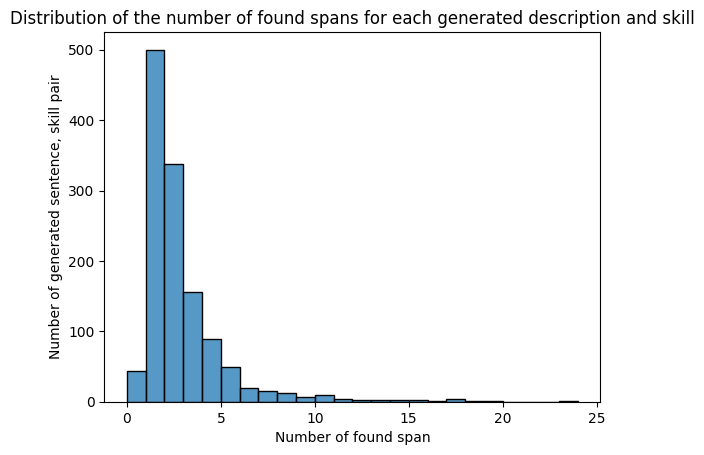

In [8]:
import seaborn as sns


annotated_support_set["nb_spans"] = annotated_support_set["spans"].apply(len)
g = sns.histplot(data=annotated_support_set, x="nb_spans", binwidth=1)
g.set_title("Distribution of the number of found spans for each generated description and skill")
g.set_xlabel("Number of found span")
g.set_ylabel("Number of generated sentence, skill pair");

No span found :

In [11]:
for i, (skill, annotated_sentence) in annotated_support_set[annotated_support_set["nb_spans"] == 0][["skill", "annotated_sentence"]].iterrows():
    print("skill : ", skill)
    print("annotated sentence : ", annotated_sentence)
    print("-"*100)

skill :  Pascal (computer programming)
annotated sentence :  Are you passionate about coding and programming languages? We are looking for a skilled software developer to join our dynamic team. As a developer, you should have experience with various programming languages such as @@Pascal@@, Prolog, Vyper, Objective-C, Java, APL, ML, Lisp, and SAS. You will be responsible for writing clean, efficient, and maintainable code using @@Pascal@@ and these languages. Your expertise in this language will be crucial in designing and implementing complex software solutions. Join us and bring your knowledge of @@Pascal (computer programming)@@ to contribute to our cutting-edge projects.
----------------------------------------------------------------------------------------------------
skill :  interpret laboratory data in medical genetics
annotated sentence :  We are seeking a highly skilled Genetic Testing Specialist to join our team. As a Genetic Testing Specialist, you will be responsible for 

### Generate SkillSpan support set

In [8]:
import pandas as pd
from tqdm.notebook import tqdm


df_train = pd.read_csv("generated/SKILLSPAN/test_final.csv")

support_set = df_train.dropna(how="any")
support_set = support_set[support_set["skills"].apply(lambda x : x[0]) != "NO LABEL"]
support_samples = support_set[["skills", "sentence"]].explode("skills")
support_samples.columns = ["skill", "sentence"]
support_samples = support_samples.to_dict("records")

spanextr = SpanExtractor(PROMPTS, "gpt-3.5")
annoted_support_samples = []
for sample in tqdm(support_samples):
    annot_sample = sample.copy()
    annot_sample["annotated_sentence"] = spanextr.extract_span(sample)
    if(annot_sample["annotated_sentence"] is not None):
        annot_sample["spans"] = re.findall(PATTERN, annot_sample["annotated_sentence"])
    else :
        annot_sample["spans"] = []
    annoted_support_samples.append(annot_sample)
    

  0%|          | 0/1272 [00:00<?, ?it/s]

Timed out Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=20). Waiting for 10 seconds.
Timed out Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=20). Waiting for 10 seconds.
Timed out Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=20). Waiting for 10 seconds.
Timed out Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=20). Waiting for 10 seconds.


In [16]:
from sys import path

path.append("../")
from gen_utils import embedd_tax

%load_ext autoreload
%autoreload 2

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
emb_df_train = embedd_tax(df_train.dropna(how="any"), key_to_embedd="sentence", show_progress=True)

  0%|          | 0/1272 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/SkillThrills/protosp01/dataset_generation/generation/../gen_utils.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tax["embeddings"] = tax[key_to_embedd].progress_apply(


In [21]:
import pickle
annotated_support_set = pd.DataFrame(annoted_support_samples)
annotated_support_set["annotated_sentence"] = annotated_support_set["annotated_sentence"].apply(lambda x : x.replace("Sentence: ", "") if x is not None else x)
annotated_support_set = emb_df_train[["sentence", "embeddings"]].merge(annotated_support_set, on="sentence", how="right")

with open("generated/SKILLSPAN/ANNOTATED_SUPPORT_SET.pkl", "wb") as f:
    pickle.dump(annotated_support_set, f)